Get hands on at - https://huggingface.co/spaces/shreerampawar/Comment_Toxicity_Detector

# 0. Install Dependencies and Bring in Data

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv('https://github.com/nicknochnack/CommentToxicity/raw/main/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [4]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [14]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [15]:
model.compile(loss='BinaryCrossentropy', optimizer='adam', metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [17]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 876s 124ms/step - loss: 0.0617 - accuracy: 0.9851 - val_loss: 0.0513 - val_accuracy: 0.9941
Epoch 2/5
6981/6981 [==============================] - 762s 109ms/step - loss: 0.0460 - accuracy: 0.9924 - val_loss: 0.0418 - val_accuracy: 0.9934
Epoch 3/5
6981/6981 [==============================] - 775s 111ms/step - loss: 0.0403 - accuracy: 0.9941 - val_loss: 0.0353 - val_accuracy: 0.9944
Epoch 4/5
6981/6981 [==============================] - 844s 121ms/step - loss: 0.0360 - accuracy: 0.9942 - val_loss: 0.0315 - val_accuracy: 0.9933
Epoch 5/5
6981/6981 [==============================] - 798s 114ms/step - loss: 0.0319 - accuracy: 0.9933 - val_loss: 0.0273 - val_accuracy: 0.9940


In [18]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

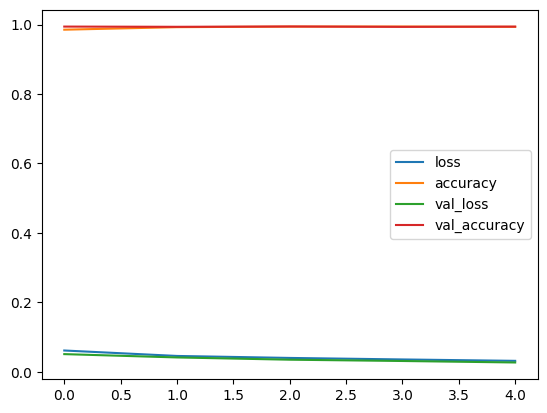

In [19]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [25]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [26]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 1s 1s/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# 4. Evaluate Model

In [28]:
from tensorflow.keras.metrics import Precision, Recall

In [29]:
pre = Precision()
re = Recall()

In [30]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)

1/1 [==============================] - 0s 54ms/step


In [42]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}')

Precision: 0.8889608383178711, Recall:0.8117055892944336


In [32]:
model.evaluate(test)

997/997 [==============================] - 51s 50ms/step - loss: 0.0286 - accuracy: 0.9940


[0.028561696410179138, 0.9939819574356079]

# 5. Test and Gradio

In [ ]:
import gradio

In [48]:
model.save('toxicity_detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
from google.colab import files
files.download('toxicity_detection.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
model = tf.keras.models.load_model('toxicity_detection.h5')

In [51]:
input_str = vectorizer('hey i freaken hate you!')

In [52]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 746ms/step


In [53]:
res

array([[8.9023811e-01, 1.0423003e-04, 1.2618441e-02, 1.1998757e-03,
        2.2345227e-01, 1.0481765e-02]], dtype=float32)

In [54]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [ ]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)